# Week 1 - Interpreting Image Classifiers

Welcome to the week 1 project of the Interpreting Machine Learning Models course! We are excited to help you unravel the mysteries behind machine learning algorithms.

## Introduction - Week 1 Challenge

It's 2050 and a mysterious virus has caused the global cat population to become hilariously clumsy and forgetful. People can often be seen watching in amusement as their feline companions stumble into walls, accidentally headbutt their own tails, and knock over everything in their way!

<center><img src='https://media.tenor.com/FJgMcZ8QcvMAAAAM/epic-fail-fall.gif'></center>

The situation quickly becomes frustrating for cat owners. Cats can no longer be left alone, as they are prone to forgetting where they put their toys and treats, and are even known to accidentally lock themselves in closets and bathrooms.

To address this problem, cat owners decide to deploy cameras equipped with machine vision to detect and track the activities of these forgetful felines. However, they want to make sure the algorithm can accurately identify cats and doesn't raise false alarms, especially while the owners are napping. To achieve this, they hire a machine learning expert(you, yes you) to interpret the algorithm.

## We need you! [TODO]

You are given a pre-trained ResNet model that is trained on Imagenet 1k dataset. Your task is to interpret "Why the ResNet model detects cats?"

For interpreting a classification task, there are multiple dimensions to choose from (Global vs Local, Model agnostic vs. specific, Inherent vs. post hoc). We will be using a Model agnostic post hoc method and deploy it at a local scale

Specifically, we will use LIME, SHAP, and integrated-gradient in this project. For each of these algorithms, you will be documenting the compute time and visualizing their explanations. At the end of the project, you'll be comparing the three evaluation approaches and assessing which you agree with most. So let's dive in!

## Setup
Before we start our mission, lets gets some gear set up. Firstly, lets install the missing packages and import the necessary libraries

### Installation of Libraries

In [ ]:
!pip install omnixai
!pip install dash
!pip install dash-bootstrap-components
## For local tunnel to a proxy server 
!npm install localtunnel

### Imports

First, we will import some usual suspects. We will use Pillow Image library to laod/create images. Finally, let us import our main weapon. Let us use [OmniXAI](https://opensource.salesforce.com/OmniXAI/latest/index.html) (Omni eXplainable AI), a Python library for explainable AI (XAI).

In [ ]:
## The usual suspects
import json
import numpy as np
import requests
import pickle

## To build our classifer
import torch
from torchvision import models, transforms

## Pillow Library Image function alias PilImage
from PIL import Image as PilImage

## Omnixai library to build our explainer
from omnixai.preprocessing.image import Resize
from omnixai.data.image import Image
from omnixai.explainers.vision import VisionExplainer
# from omnixai.visualization.dashboard import Dashboard

## Image Data and Classifier

In [ ]:
## Let's start by loading the image that we want to explain
url = "https://occ-0-2794-2219.1.nflxso.net/dnm/api/v6/E8vDc_W8CLv7-yMQu8KMEC7Rrr8/AAAABbXlHC_UGJZBTU7MLgi3j-qC6yYxU4XkR0s7liVCJlCPNUWONNh6tFf9AeaWiLZ7yWb2D_m3I8hRWIW6xXvqnYh9Qk0hSrDdWXkd.jpg?r=278"
download = requests.get(url, stream=True).raw

## TODO: Read the image using Pillow and convert the image into RBG
### Hint: Use PilImage to read and convert
image = Image(PilImage.open(download).convert('RGB'))

# image = Image(...)

Image Size -:(1, 720, 1280, 3)


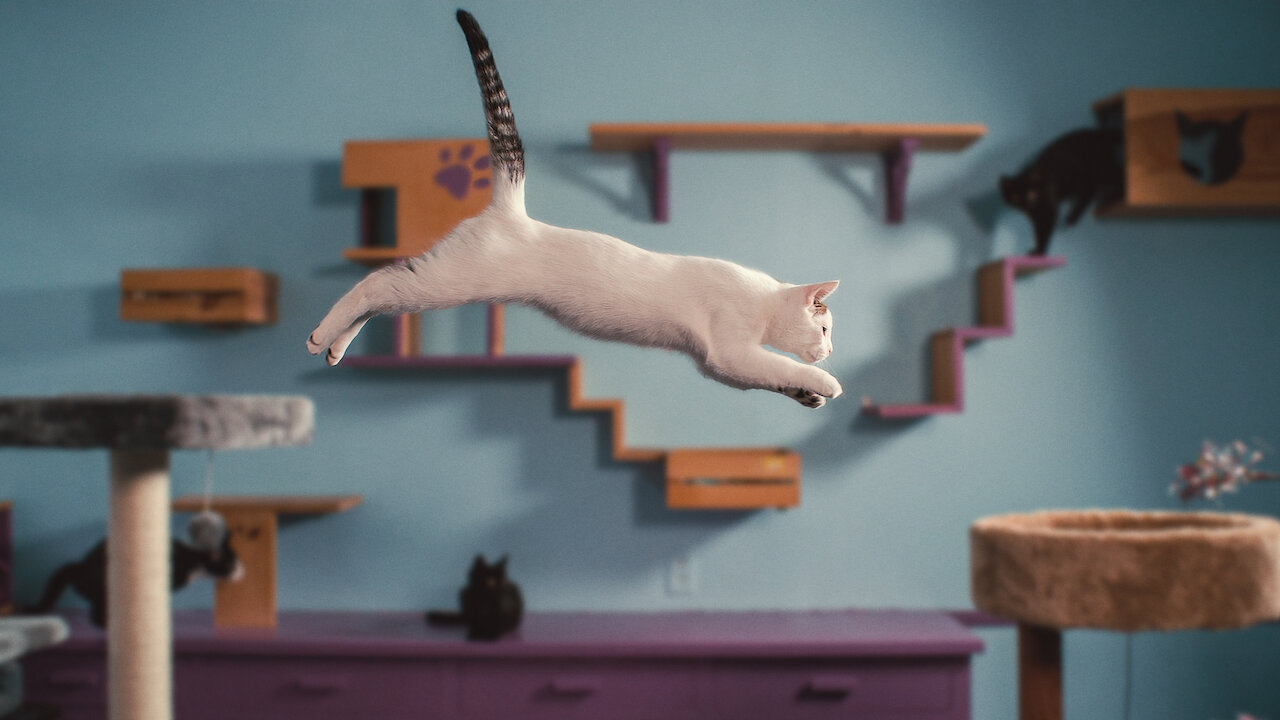

In [ ]:
## TODO: Print the image shape and view the image
## Print the image shape
print(f"Image Size -:{image.shape}")

# Now, let's view it
# import matplotlib.pyplot as plt
# plt.imshow(image)
# plt.show()
# Shh! They are napping...
image.to_pil()

In [ ]:
## Before we build our classifier, lets make sure to setup the device.
## To run this notbeook via GPU: Edit->Notebook settings ->Hardware accelerator -> GPU
## If your GPU is working, device is "cuda"
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
## TODO: Lets build our classification model. We will use pre-trained ResNet34 model from PyTorch torchvision models.
## Make sure to load the model onto the device for gpu
from torchvision.models import ResNet34_Weights, resnet34
weights = ResNet34_Weights.DEFAULT
model = resnet34(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
# Lets get a summary of our model using torchsummary
from torchsummary import summary
## TODO: Print the model summary
### Hint: Use image shape for input_size
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
## Did you notice the last layer had 1000 classes. Lets import all the classes. 
## We will later pass this to our explainer
classes_url = 'https://gist.githubusercontent.com/DaniFojo/dad37f5bf00ddeb56ed36daf561dbf69/raw/bd006b86300a5886ac7f897a44b0525b75a4b5a1/imagenet_labels.json'
imagenet_classes = json.loads(requests.get(classes_url).text)
idx2label =  {int(k):v for k,v in imagenet_classes.items()}

first_label = idx2label[next(iter(idx2label))]
print(f"The first class label from the ImageNet dataset is: '{first_label}'")

The first class label from the ImageNet dataset is: 'tench, Tinca tinca'


## Buiding our Explainer

To build our Explainer for our model, we will use [Vision Explainer](https://opensource.salesforce.com/OmniXAI/v1.2.3/omnixai.explainers.vision.html) by OmniXAI. The explainer needs some pre-processing and post-processing.

### Pre-processor

In [ ]:
## TODO: Build the pre-processor pipeline for the explainer

# The preprocessing function should convert the image to a Tensor 
# and then Normalise it

# 1. Compose the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  
  ])

In [ ]:
## TODO: Create the preprocess logic using the transformation built in previous cell
### Hint: Use torch.stack and load the images to the device

def preprocess(images):
   """
   Args:
     images: Sequence of images to preprocess using the composed 
             transformations created above

   Returns:  
     preprocessed_images: Sequence of preprocessed images
   """
   image_tensors_transform = [transform(single_image.to_pil()) for single_image in images]

   preprocessed_images = torch.stack(image_tensors_transform, dim=0).to(device)
   return preprocessed_images

### Post-processor

Next, we need to define our post-processing function:

In [ ]:
## TODO: Build the post-processor function for the explainer
# We will apply a softmax function to the logits obtained in the last layer
# in order to convert the prediction scores to probabilities

def postprocess(logits):
   """
   Args:
     logits: Logits from the last layer of the model
  
   Returns:
     postprocessed_outputs: Output from the Softmax layer applied to the logits
   """
   posprocessed_output = torch.softmax(logits, dim=1)
   return posprocessed_output

### Vision Explainer
Now, construct the explainer using the VisionExplainer class. You'll want to provide it a list of the three explainer types you'd like to try: LIME, SHAP, and integrated gradient. Be sure to check the documentation for the appropriate arguments! See the sample code for VisionExplainer [here](https://opensource.salesforce.com/OmniXAI/v1.2.3/tutorials/vision.html).

In [ ]:
#TODO: Build the VisionExplainer by filling in the blanks
explainer = VisionExplainer(
     explainers=["lime","shap","integrated_gradient"],
     mode="classification",
     model=model,
     preprocess=preprocess,
     postprocess=postprocess,

 )

Now, we can generate some explanations for each of the explainers using the explainer.explain() method:

In [ ]:
## Time to generate the explanations
local_explanations = explainer.explain(Image(
    data=np.concatenate([
        image.to_numpy()]),
    batched=True
))

  0%|          | 0/1000 [00:00<?, ?it/s]

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
## Lets write the local_explantions to a pickle file. We will use this in our dashboard
with open('file.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(local_explanations, file)

## Dashboard
Now let's create a Dashboard to visualize our different explainers that we just built

predict:


lime:



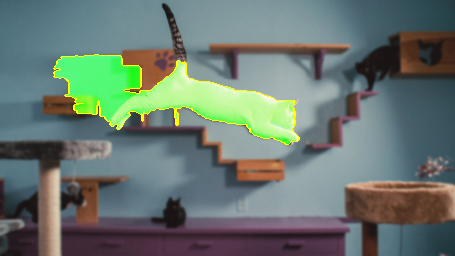
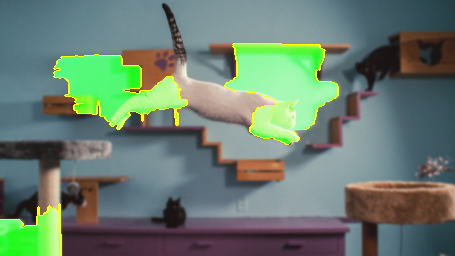

shap:



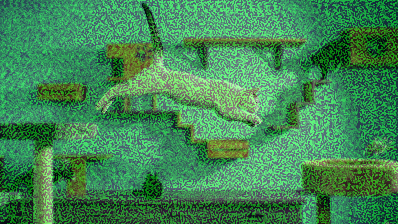
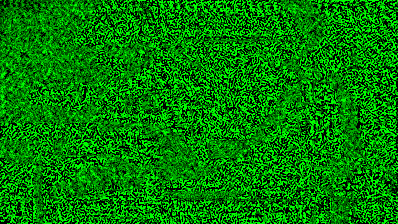

integrated_gradient:



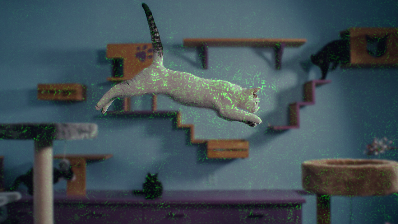
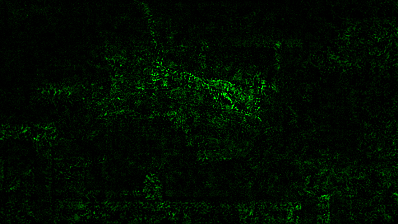

In [ ]:
# index refers to the index of the image in the dataset
index=0
# shap_results are from shap_results = shap.explain(cats)
for name, explanations in local_explanations.items():
    print(f"{name}:")
    explanations.ipython_plot(index, class_names=idx2label)

## Outro

🎉Yay, you did it! Now that we've seen the explantions, you are ready to answer some questions about the various explanations!

1. What are your thoughts on Interpretable AI?
Pretty good tool to add for training the deep learning models.
2. Compare the various explanations. Which method do you agree with most, why?
Integrated gradient, followed by lime. It is closest to the actual image.
3. Do you think the ResNet model is good enough for cat owners?
I tested on multiple images, also resized the image to smaller size. My answer is No, the image, I tested upon gives the category of balance beam, cat is not in top-5.
It might improve upon transfer learning specifically on cat images.

## Bonus (Extension)
Document the computation time for each explainer: LIME, SHAP, and integrated-gradient.

In [ ]:
## Lets use hugging face cats vs dogs dataset
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
## Now we will load 5 cat images from the dataset
from datasets import load_dataset

## Feel free to change this number. In order to not run out of RAM we use 5 images
NUM_IMAGES = 3
dataset = load_dataset("cats_vs_dogs")
cats_data = dataset['train'][0:NUM_IMAGES]['image']
cats_data

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/.cache/huggingface/datasets/cats_vs_dogs/default/1.0.0/d4fe9cf31b294ed8639aa58f7d8ee13fe189011837038ed9a774fde19a911fcb. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7F74335A46D0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x281 at 0x7F74334AD670>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=489x500 at 0x7F74334ADC70>]

In [ ]:
## Notice that the image sizes are different. 
## TODO: Convert them to same size using transforms.Resize

transform_resize = transforms.Compose([
    transforms.Resize((224,224))
])

In [ ]:
## Lets use the transformer and stack the images
# TODO: Use `transform_resize` and `np.stack`

cats = np.stack([transform_resize(cat) for cat in cats_data])

In [ ]:
## We will use this explainer function to create independant explainer 
def explainer(explainer):
  return VisionExplainer(
    explainers=[explainer],
    mode="classification",
    model=model,
    preprocess=preprocess,
    postprocess=postprocess,
  )

In [ ]:
### TODO: Initialize the explainer for 'Lime', 'SHAP', and 'integrated gradient'
lime = explainer("lime")
shap = explainer("shap")
ig = explainer("integrated_gradient")

In [ ]:
## Let us time the results. We will use built-in magic commands in jupyter 
%time lime_results = lime.explain(cats)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 23.8 s, sys: 355 ms, total: 24.1 s
Wall time: 28.7 s


predict:


lime:



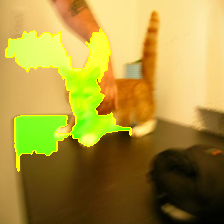
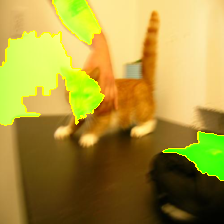

In [ ]:
# index refers to the index of the image in the dataset
index=0
# shap_results are from shap_results = shap.explain(cats)
for name, explanations in lime_results.items():
    print(f"{name}:")
    explanations.ipython_plot(index, class_names=idx2label)

In [ ]:
%time shap_results = shap.explain(cats)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



CPU times: user 1min 35s, sys: 1.69 s, total: 1min 36s
Wall time: 1min 38s


predict:


shap:



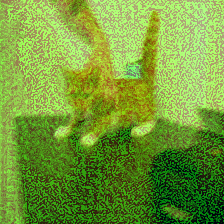
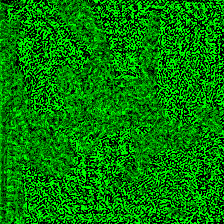

In [ ]:
# index refers to the index of the image in the dataset
index=0
# shap_results are from shap_results = shap.explain(cats)
for name, explanations in shap_results.items():
    print(f"{name}:")
    explanations.ipython_plot(index, class_names=idx2label)

In [ ]:
%time ig_results = ig.explain(cats)

CPU times: user 6.49 s, sys: 36 ms, total: 6.53 s
Wall time: 6.59 s


predict:


integrated_gradient:



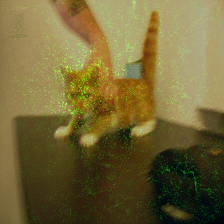
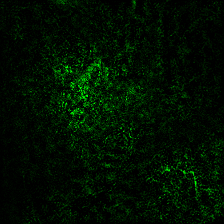

In [ ]:
# index refers to the index of the image in the dataset
index=0
# shap_results are from shap_results = shap.explain(cats)
for name, explanations in ig_results.items():
    print(f"{name}:")
    explanations.ipython_plot(index, class_names=idx2label)

In [ ]:
## Combine all results
combine_results = lime_results
combine_results['shap'] = shap_results['shap']
combine_results['ig'] = ig_results['integrated_gradient']

## Lets visualize the results on the Dashboard
dashboard = Dashboard(
    instances=Image(cats,batched =True),
    local_explanations=combine_results,
    class_names=idx2label
)
## Do not change the port
## <NOTE> Once you open the link, it might take a minute or two for the website to load fully. Be patient :)
dashboard.show(port=8000)

## Final Thoughts🎉

Congratulations on finishing the bonus sections. It is an impressive feat!

---
Please share your observations about the computation time for each of the explainers and recommend a method based on this and any other relevant factors, such as effectiveness or accuracy? If your recommendation differs from a previous suggestion, please explain the reason for this change.